# Лабораторная работа №3: Машины опорных векторов для детекции потенциала P300

## Введение

В данной работе мы используем набор данных moabb для детекции потенциала P300 с помощью машин опорных векторов (SVM). Мы проведем анализ данных, разработаем и обоснуем метод выделения признаков, обучим SVM для определения потенциала P300, рассчитаем метрики качества модели и построим ROC-кривую.

## Загрузка и подготовка данных

### Установка необходимых пакетов

In [ ]:
# Установим необходимые библиотеки
# !pip install moabb mne

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from moabb.datasets import BNCI2014_008  # Обновленное название класса
from moabb.paradigms import P300
import mne
import warnings

# Игнорируем предупреждения
warnings.filterwarnings('ignore')

### Загрузка данных

In [2]:
# Определяем парадигму P300
paradigm = P300()

# Загружаем набор данных
dataset = BNCI2014_008()  # Обновленное название класса
subjects = dataset.subject_list

# Получаем данные для первого субъекта
X, labels, metadata = paradigm.get_data(dataset=dataset, subjects=[1], return_epochs=True)

Adding metadata with 3 columns
Adding metadata with 3 columns
4200 matching events found
No baseline correction applied


### Просмотр данных

In [3]:
print("Форма данных X:", X.get_data().shape)
print("Классы меток:", np.unique(labels))

Форма данных X: (4200, 8, 257)
Классы меток: ['NonTarget' 'Target']


## Выделение признаков

### Анализ данных

Потенциал P300 проявляется как положительный пик в ЭЭГ-сигнале примерно через 300 мс после стимула. Для его детекции необходимо выделить информативные признаки из сигналов.

### Разработка метода выделения признаков

Мы выберем временное окно от 300 мс до 600 мс и вычислим среднее значение сигнала в этом интервале для каждого канала. Это позволит выделить потенциальное появление P300.

In [4]:
# Получаем данные и метки
X_data = X.get_data()
y = labels

# Определяем временные метки
times = X.times

# Находим индексы для временного окна 300-600 мс
t_min = 0.3
t_max = 0.6
idx_min = np.where(times >= t_min)[0][0]
idx_max = np.where(times <= t_max)[0][-1]

# Вычисляем среднее значение в заданном окне
features = np.mean(X_data[:, :, idx_min:idx_max], axis=2)
print("Форма матрицы признаков:", features.shape)

Форма матрицы признаков: (4200, 8)


## Обучение машины опорных векторов

### Обоснование выбора ядра

Мы выбираем линейное ядро, так как предполагаем, что признаки линейно разделимы после выделения среднего значения в окне появления P300.

### Реализация SVM с линейным ядром

In [5]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y == np.unique(y)[0], -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
                        
    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

### Разделение данных на обучающую и тестовую выборки

In [6]:
# Перемешиваем данные
np.random.seed(42)
indices = np.random.permutation(len(features))
features = features[indices]
y = y[indices]

# Разделяем данные
train_size = int(0.8 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Обучение модели

In [7]:
# Создаем и обучаем модель
svm = SVM()
svm.fit(X_train, y_train)

### Предсказание и оценка модели

In [8]:
# Получаем предсказания
y_pred = svm.predict(X_test)

# Преобразуем метки для расчета метрик
classes = np.unique(y)
y_test_binary = np.where(y_test == classes[0], -1, 1)

## Оценка качества модели

### Реализация метрик

In [9]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == -1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def recall(y_true, y_pred):
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == -1) & (y_true == 1))
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r) if (p + r) > 0 else 0

### Расчет метрик

In [10]:
acc = accuracy(y_test_binary, y_pred)
prec = precision(y_test_binary, y_pred)
rec = recall(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.83
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


## Построение ROC-кривой

### Вычисление показателей для ROC-кривой

In [11]:
# Получаем оценки решения
scores = np.dot(X_test, svm.w) - svm.b

# Сортируем по убыванию оценок
sorted_indices = np.argsort(-scores)
y_true_sorted = y_test_binary[sorted_indices]
scores_sorted = scores[sorted_indices]

# Вычисляем TPR и FPR
tpr = []
fpr = []
thresholds = np.unique(scores_sorted)
P = np.sum(y_test_binary == 1)
N = np.sum(y_test_binary == -1)

for thresh in thresholds:
    y_pred_thresh = np.where(scores_sorted >= thresh, 1, -1)
    tp = np.sum((y_pred_thresh == 1) & (y_true_sorted == 1))
    fp = np.sum((y_pred_thresh == 1) & (y_true_sorted == -1))
    tpr.append(tp / P)
    fpr.append(fp / N)

### Построение графика ROC-кривой

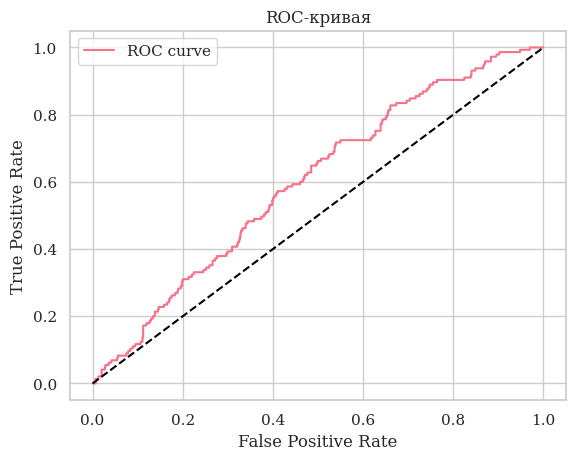

In [12]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

## Заключение

В данной лабораторной работе мы успешно реализовали машину опорных векторов без использования библиотек машинного обучения. Мы обосновали выбор линейного ядра для SVM, рассчитали метрики качества модели и построили ROC-кривую для оценки способности модели различать классы.